# Getting Started with Error Mitigation with mitiq on Braket 

The presence of errors in quantum computing ultimately hinders their application as well. The simplest model, i.e. local or globabl depolarizing noise, represents how noise generally removes information from a quantum system. Error mitigation attempts to, similar to improving a signal-to-noise ratio, generally at the cost of repeated measurements. 

mitiq is an open source Python toolkit for implementing error mitigation techniques, which covers a breadth of different methodoloies and tools. 

In these notebooks, we show to utilize mitiq with Amazon Braket, specifically focusing on utilizing Program Sets to orchestrate our job submissions. 

## Overview on mitiq 
 
mitiq contains two methods for applying error mitigation generally. The first can be thought of as an automated way of calling error mitigation functions and then having an output returns. The second unpacks this procedure, separating the creation of circuits and their application and reassembly. 

Further details can be found at https://mitiq.readthedocs.io/en/stable/guide/guide.html

In this example, we focus on the latter, as 

## Overview of Error Mitigation Techniques

The mitiq library provides numerous error mitigation approaches as pre-implemented strategies. 

### Using Verbatim Circuits

For most of these approaches, we will want to treat the circuit as a Verbatim circuit. This creates a more reliable thread between the submitted circuits and the hypothetical noise model which is being manipulated. If we were to submit as a non-verbatim circuit, we would likely 

#### Readout Error Mitigation

Readout error mitigation is perhaps the most common error mitigation technique. The standard approach involves the construction of a confusion matrix, relating prepared input states to  measured output states. Specifically

$$ C_{ij} = {\rm Tr}{\mathcal{E}[|i\rangle \langle i|]|j\rangle \langle j | }$$

In postprocessing, we can apply the inverse of this matrix to try and account for these errors. The statistical variance is increased as a result, related by the cost of the inverse matrix generally. However, because this is essentially a one-time-cost, and can drastically helkp to defend against readout errors, this approach is extremely common.  


#### Zero Noise Extrapolation

#### Probabilistic Error Cancellation

Probabilistic error cancellation forms the backbone of some of the most successful error mitigation strategies used  today, but can also be the most technical to implement. 

First, we define a problem of interest. For the moment, we will look at a one-dimensional ising model. 

The Hamiltonian can be defined as $$ H = \sum_{\langle i,j\rangle } Z_i Z_j + g \sum_j X  $$. Thus, we will require two circuits, an all-X circuit and an all Z circuit to measure the observables. 

In [ ]:
# first, let's consider a problem of interest

def ising_observables(nq):
    return 

def process_ising_model(z_res : dict, x_res : dict):
    pass




q: 0.3
0.6
q: 0.32
0.6
q: 0.33999999999999997
0.6
q: 0.36
0.6
q: 0.38
0.6
q: 0.4
0.6
q: 0.42
0.6
q: 0.44
0.6000000000000001
q: 0.45999999999999996
0.6
q: 0.48
0.6
q: 0.5
0.6


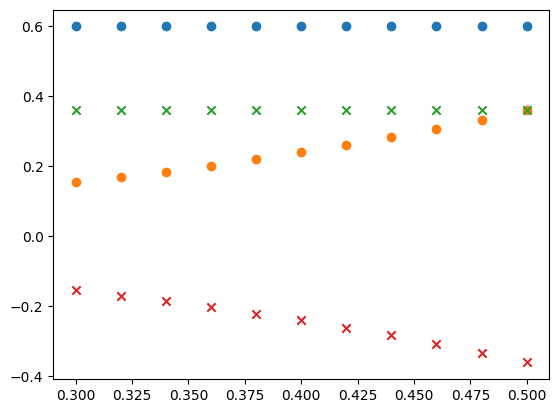

In [17]:
import matplotlib.pyplot as plt

import numpy as np 

def expectation(f,p, q = None):
    if q:
        return np.dot(
            np.multiply(
                f,
                np.divide(
                    p,
                    q
                    )
                ),
            q
                      )
    return np.dot(f,p)

def variance(f,p,q = None):
    ev = expectation(f,p,q)
    print(ev)
    if q:
        return np.sum(
            np.divide(
                np.square(
                    np.multiply(f,p) - ev*np.array(q)
                    ),
                    q
                )
            )
    return np.dot(f**2,p) - np.dot(f,p)**2

def gradient(f, p, q):
    ev = expectation(f,p,q)
    grad = ev**2 - np.divide(
        np.square(np.multiply(f,p)),
        q
    )
    return grad

f = [0.0,1.0]
pi = 0.4
p = [pi, 1-pi]

evs = []
vs  = []
g0s = []
g1s = []
xs = np.linspace(0.3, 0.5, 11)
for qi in xs:
    q = [qi, 1-qi]
    print(f'q: {qi}')
    e,v = expectation(f,p,q), variance(f,p,q)
    g = gradient(f,p,q)
    evs.append(e)
    vs.append(v)
    g0s.append(g[0])
    g1s.append(g[1])

plt.scatter(xs,evs)
plt.scatter(xs,vs)
plt.scatter(xs,g0s, marker= 'x')
plt.scatter(xs,g1s, marker= 'x')


# Not

